# Exercise

Inject the correlated samples into our existing `bw2data` project.

1. Import `bw2data` (e.g. `import bw2data as bd`) and switch to the right project.
2. Get the `id` values of the nodes needed to update the `dp_correlated.add_persistent_array` indices. For example, instead of `natural_gas_product` we should have `bd.get_node(name="something").id`. **Don't forget** to create a **new** `dp_correlated` datapackage.
3. Get the datapackage for our `bw2data` graph:

```python
functional_unit, data_objs, _ = bd.prepare_lca_inputs(
    {bicycle_node: 1},  # note: You need to `.get_node()` the bicycle node :)
    method=('IPCC',), 
)
```
4. Do LCA with the "base" datapackages, combined with `dp_correlated`, and do Monte Carlo calculations

In [1]:
import bw_processing as bwp
import matrix_utils as mu
import bw2calc as bc
import numpy as np
import seaborn as sb
import pandas as pd

10:17:30+0000 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


1. Import bw2data (e.g. import bw2data as bd) and switch to the right project.

In [2]:
import bw2data as bd
bd.projects.set_current("Bicycle example")

2. Get the id values of the nodes needed to update the `dp_correlated.add_persistent_array` indices.

We need the following:

* natural_gas_product
* carbon_fibre_process
* co2

We can do this with `bd.get_node()`:

In [3]:
bw2data_co2 = bd.get_node(name="Carbon Dioxide", database="🚲")
bw2data_natural_gas_product = bd.get_node(name="natural gas", database="🚲")
bw2data_carbon_fibre_process = bd.get_node(name="carbon fibre production", database="🚲")

# Check to make sure
bw2data_co2, bw2data_natural_gas_product, bw2data_carbon_fibre_process

('Carbon Dioxide' (kilogram, GLO, ('air',)),
 'natural gas' (megajoule, GLO, None),
 'carbon fibre production' (None, DE, None))

2. ...create a **new** `dp_correlated` datapackage

In [4]:
ng_samples = np.random.triangular(200, 237, 300, size=100)
co2_samples = 26.6 / 237 * ng_samples * np.random.normal(loc=1, scale=0.025, size=100)

In [5]:
dp_correlated = bwp.create_datapackage(seed=42)

In [6]:
dp_correlated.add_persistent_array(
    matrix='technosphere_matrix',
    # Note: The use of .id here to get the integer ids
    indices_array=np.array([(bw2data_natural_gas_product.id, bw2data_carbon_fibre_process.id)], dtype=bwp.INDICES_DTYPE),
    data_array=ng_samples.reshape((1, -1)),
    flip_array=np.array([True]) ,
)
dp_correlated.add_persistent_array(
    matrix='biosphere_matrix',
    indices_array=np.array([(bw2data_co2.id, bw2data_carbon_fibre_process.id)], dtype=bwp.INDICES_DTYPE),
    data_array=co2_samples.reshape((1, -1)),
)

3. Get the datapackage for our `bw2data` graph

In [7]:
bw2data_bicycle = bd.get_node(name="bicycle", database="🚲")
bw2data_bicycle

'bicycle' (number, GLO, None)

In [8]:
functional_unit, data_objs, _ = bd.prepare_lca_inputs(
    {bw2data_bicycle: 1},  # Here you don't need the `.id`, but you can also use it if you want
    method=('IPCC',), 
)

4. Do LCA with the "base" datapackages, combined with `dp_correlated`, and do Monte Carlo calculations

In [9]:
lca = bc.LCA(
    demand=functional_unit,
    data_objs=data_objs + [dp_correlated],
    use_distributions=True,
    use_arrays=True,
)
lca.lci()
lca.lcia()

results, corr_params = [], []

for _ in range(250):
    next(lca)
    results.append(lca.score)
    corr_params.append({
        'co2': lca.biosphere_matrix[
            lca.dicts.biosphere[bw2data_co2.id], 
            lca.dicts.activity[bw2data_carbon_fibre_process.id]
        ],
        'ng': -1 * lca.technosphere_matrix[
            lca.dicts.product[bw2data_natural_gas_product.id], 
            lca.dicts.activity[bw2data_carbon_fibre_process.id]
        ],
    })

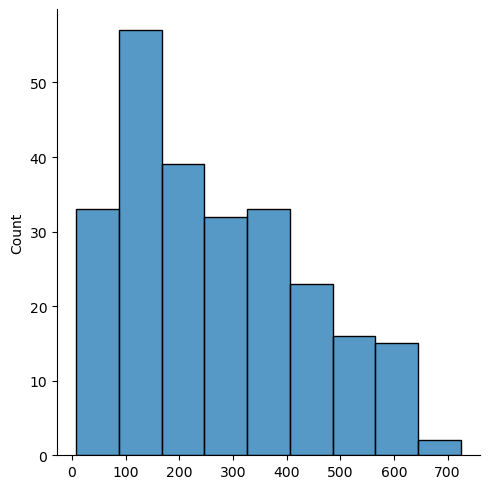

In [10]:
sb.displot(np.array(results))

<Axes: xlabel='ng', ylabel='co2'>

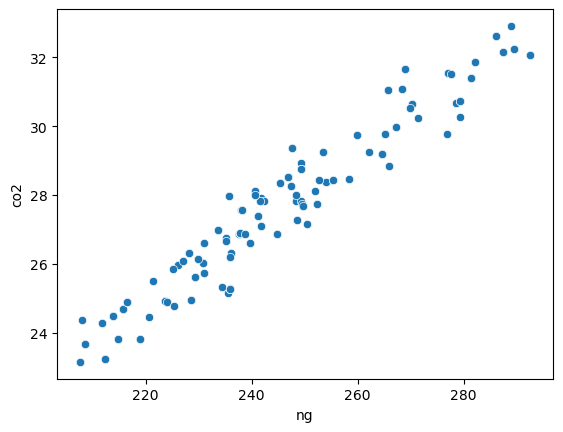

In [11]:
sb.scatterplot(data=pd.DataFrame(corr_params), x='ng', y='co2')